# NYC Yellow Taxi 2020-2021

Przedmiotem analizy jest zbiór Yellow Taxi z lat 2020-2021 https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page

**Dostępne dane kończą się na lipcu 2021 roku**

## Opis na stronie

Według opisu na stronie w zbiorze znajdują się dane na temat kursów Yellow i Green Taxi oraz For-Hire Vehicle (FHV). Nas interesuje tylko zbiór dotyczących "żółtych" taksówek.

Z interesujących nas dokumentów poza danymi znajdziemy tam też:
* user guide https://www1.nyc.gov/assets/tlc/downloads/pdf/trip_record_user_guide.pdf
* słownik danych dla Yellow Taxi Trips https://www1.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf
* słownik stref https://s3.amazonaws.com/nyc-tlc/misc/taxi+_zone_lookup.csv
* pliki graficzne z mapami stref
* shapefile stref https://s3.amazonaws.com/nyc-tlc/misc/taxi_zones.zip

## User guide

W pierwszej kolejności przeglądamy user guide.
* Dane Yellow Taxi zawierają informacje o:
    * czasach startu i końca podróży
    * miejsach startu i końca podróży
    * pokonanych odległościach
    * opłatach i ich rodzajach
    * liczbie pasażerów
*  Dane moglibyśmy wstępnie przekształcić i ściągnąć z https://opendata.cityofnewyork.us/ (nawet korzystając z API), ale zadanie ma być wykonane w Pythonie, więc nie skorzystamy z tej opcji.
* Żółte taksówki mogą podejmować pasażerów "z ulicy" we wszystkich dzielnicach.
* Zielone taksówki mogą podejmować pasażerów "z ulicy" we wszystkich dzielnicach, poza określoną strefą na Manhattanie.
* Pojazdy FHV działają na innych zasadach niż taksówki, ale są dla nich konkurencją we wszystkich dzielnicach (user guide nic jednak nie mówi o tym, żeby można z nich było korzystać na zasadzie "street hail").

## Data dictionary

Według słownika w danych znajdziemy następujące kolumny:
1. `VendorID` ID dostawcy danych (kategoryczna).
1. `tpep_pickup_datetime` Data i czas startu taksometru (możemy założyć, że to początek podróży).
1. `tpep_dropoff_datetime` Data i czas zatrzymania taksometru (możemy założyć, że to koniec podróży).
1. `Passenger_count ` Ilość pasażerów (wprowadzana przez kierowcę, co może być źródłem dodatkowego błędu).
1. `Trip_distance` Długość podróży w milach wg taksometru.
1. `PULocationID` Strefa, w której uruchomiony został taksometr (możemy założyć, że to miejsce początkowe podróży).
1. `DOLocationID` Strefa, w której zatrzymany został taksometr (możemy założyć, że to miejsce końcowe podróży).
1. `RateCodeID` Ostatnia aktywna taryfa w trakcie podróży (kategoryczna).
1. `Store_and_fwd_flag` Flaga wskazująca czy dany rekord został wysłan z opóźnieniem do bazy danych ze względu na brak połączenia z serwerem (kategoryczna).
1. `Payment_type` Kod sposobu płatności za podróż (kategoryczna). Niektóre z wymienionych typów mogą wskazywać na potencjalne problemy z przejazdem z punktu widzenia biznesu (`Dispute`, `No charge`, `Voided trip`).
1. `Fare_amount` Opłata obliczona przez taksometr.
1. `Extra` Dodatkowe nałożone opłaty.
1. `MTA_tax` Podatek MTA.
1. `Improvement_surcharge` Dodatkowa opłata ("podatek") ??? Pobierana od 2015.
1. `Tip_amount ` Kwota napiwku w przypadku opłacenia go kartą kredytową.
1. `Tolls_amount` Całkowita kwota opłat drogowych pobranych w trakcie podróży.
1. `Total_amount ` Całkowita kwota do zapłacenia przez pasażerów, bez napiwków płaconych gotówką.

## Wstępne założenia

Od czasu wejścia usług "car-charingowych" typu Uber / Lyft taksówki muszą bardziej walczyć o klienta. Z opisu datasteu i wiedzy ogólnej możemy stwierdzić, że ich potencjalną przewagą w Nowym Jorku jest możliwość złapania taksówki "z ulicy" ("street hail") - w Uberze nie jest to możliwe.

Skoro tak, to na miejscu biznesu chciałbym wiedzieć gdzie popyt na przejazdy dla danego dnia i godziny jest największy, żeby potencjalny klient wahający się między FHV, a taksówką miał ułatwione zadanie - jeżeli nie zdecydował się od razu na wyciągnięcie telefonu, a zobaczył taksówkę na ulicy to może zdecyduje się na jej zatrzymanie.

Podzbiorem taksówek, który nas interesuje jest Yellow Taxi - to oznacza, że poza FHV konkurencję stanowią Green Taxis, nawet w przypadku "street hail". Z przewodnika użytkownika wiemy  jednak, że istnieją strefy w NYC, w których tylko żółte taksówki mogą podejmować klientów "z ulicy".

Na miejscu biznesu chciałbym więc wysyłać swoje pojazdy w "żółte" strefy, w których wiem, że o danej porze będzie największy popyt - "zielone" taksówki nie podbiorą mi klientów z ulicy, a ja potencjalnie odbiorę niezdacydowanych klientów FHV, nie wspominając już o tych, którzy z założenia chcą jechać taksówką (nie chcemy, żeby musieli długo czekać aż wolna taksówka pojawi się w zasięgu ich wzroku).

Można by stwierdzić, że w takim razie powinnniśmy zawsze utrzymywać wysoką liczebność Yellow Taxi w najpopularniejszych żółtych strefach, ale nie byłoby to efetktywne kosztowo (na myśl przychodzi "sowiecka szkoła designu", gdzie wszędzie stosowano naddatki materiałowe, nie licząc się z kosztami). Dlatego jako biznes chciałbym wiedzieć z wyprzedzeniem jaki popyt prawdopodobnie będzie w jakiej "żółtej" strefie, żeby wcześniej skierować tam odpowiednią ilość pojazdów, jednocześnie wycofując je z tych stref, które w najbliższej przyszłości będą miały ten popyt obniżony.

Zgaduję w ciemno, że w "zwykłych" warunkach popyt ten można przewidzieć na podstawie analizy szeregów czasowych - przy tej skali powinno dać się zauważyć pewne wzorce. W założonym przedziale czasowym mamy 2 miesiące w roku 2020, które nie były jeszcze pandemiczne - na ich podstawie będziemy mogli wstępnie zweryfikować tę tezę (czy w ogóle jest sens patrzeć na ten problem z punktu widzenia szeregów czasowych, czy też od razu powinniśmy przeformułować go na problem regresji). Oczywiście spojrzymy tutaj tylko na fragment danych - nie będziemy w tej analizie przewidywać wszystkich stref tylko np. najpopularniejszą (w dlaszej części będziemy musieli rozważyć sensowność takiego podejścia - czy to się da w ogóle skalować, czy np. będziemy musieli jeszcze bardziej ograniczyć ilosć stref, dla których będziemy przewidywać popyt).

Dodatkowo:
1. Facebook (Meta) opublikował bibliotekę [Prophet](https://facebook.github.io/prophet/) znacznie upraszczającą przewidywanie szeregów czasowych dla mocno sezonowych danych (a prawdopodobnie takie są nasze dane). Dodatkowo potrafi wykryć zmianę trendu, a w przypadku tego zakresu czasowego na pewno taka wystąpi :)
1. Właściwie nigdy nie robiłem tego typu przewidywania, więc pora spróbować :)

### Sformułowanie problemu
Nasz problem formułujemy zatem tak:
>Jaki będzie popyt w danej "żółtej" strefie na pdostawie danych historycznych? (idealnie w rozdzielczości godzinowej)

I defniujemy sobie 2 ogólne kroki do jego zgłębienia:
1. Czy w normalnej (nie-COVIDowej) sytuacji w ogóle jesteśmy w stanie przewidywać to przy użyciu analizy szeregów czasowych?
1. Jeżeli na pierwsze pytanie odpowiemy pozytywnie, to czy będziemy w stanie stworzyć model dla "nowej" rzeczywistości?

## Słownik stref i shapefile stref
Ponieważ,jak już wcześniej zauważyliśmy, patrząc na same taksówki istnieje obszar miasta, gdzie "żółte" pojazdy nie mają konkurencji w postaci "zielonych", sprawdźmy czy łatwo będziemy w stanie odfiltrować kursy rozpoczynające się w tych strefach.

Słownik ściągnęlismy do folderu "data", dane shapefile do "data/taxi_zones".

In [3]:
from pathlib import Path

In [4]:
DATA_FOLDER = Path('data')
SHP_FOLDER = DATA_FOLDER / 'taxi_zones'

In [6]:
import pandas as pd

In [7]:
zones = pd.read_csv(DATA_FOLDER / 'taxi+_zone_lookup.csv')

In [5]:
zones.head()

LocationID        Borough                     Zone service_zone
0           1            EWR           Newark Airport          EWR
1           2         Queens              Jamaica Bay    Boro Zone
2           3          Bronx  Allerton/Pelham Gardens    Boro Zone
3           4      Manhattan            Alphabet City  Yellow Zone
4           5  Staten Island            Arden Heights    Boro Zone

User guide mówi, że zielone taksówki bywają nazywane "boro taxis" i pierwszy rzut oka na słownik zdaję się wskazywać na to, że po nazwach stref jesteśmy w stanie wyciągnąć `LocationID` dla "żółtej" strefy na Manhattanie.

Sprawdźmy jakie mamy `service_zone`s.

In [6]:
zones['service_zone'].value_counts()

Boro Zone      205
Yellow Zone     55
Airports         2
EWR              1
Name: service_zone, dtype: int64

Wygląda na to, że "żółta" strefa powinna by ć łatwa do odfiltrowania

Patrząc na grafikę w User Guide i tę na https://www1.nyc.gov/assets/tlc/images/content/pages/about/taxi_zone_map_manhattan.jpg możemy w przybliżeniu zobaczyć jakie `LocationID` należą do "żółtej strefy. 

![](https://www1.nyc.gov/assets/tlc/images/content/pages/about/taxi_zone_map_manhattan.jpg)

Ostatnie "żółte" strefy na Manhattanie idąc od południowego-zachodu to `24`, `43`, `236` i `262`.  

Porównajmy mapę z danymi w słowniku (wizualnie).

In [7]:
zones.loc[zones['service_zone'] == 'Yellow Zone']

LocationID    Borough                                           Zone  \
3             4  Manhattan                                  Alphabet City   
11           12  Manhattan                                   Battery Park   
12           13  Manhattan                              Battery Park City   
23           24  Manhattan                                   Bloomingdale   
42           43  Manhattan                                   Central Park   
44           45  Manhattan                                      Chinatown   
47           48  Manhattan                                   Clinton East   
49           50  Manhattan                                   Clinton West   
67           68  Manhattan                                   East Chelsea   
78           79  Manhattan                                   East Village   
86           87  Manhattan                       Financial District North   
87           88  Manhattan                       Financial District South   
89           90  Manhattan                                       Flatiron   
99          100  Manhattan                               Garment District   
102         103  Manhattan  Governor's Island/Ellis Island/Liberty Island   
103         104  Manhattan  Governor's Island/Ellis Island/Liberty Island   
104         105  Manhattan  Governor's Island/Ellis Island/Liberty Island   
106         107  Manhattan                                       Gramercy   
112         113  Manhattan                        Greenwich Village North   
113         114  Manhattan                        Greenwich Village South   
124         125  Manhattan                                      Hudson Sq   
136         137  Manhattan                                       Kips Bay   
139         140  Manhattan                                Lenox Hill East   
140         141  Manhattan                                Lenox Hill West   
141         142  Manhattan                            Lincoln Square East   
142         143  Manhattan                            Lincoln Square West   
143         144  Manhattan                            Little Italy/NoLiTa   
147         148  Manhattan                                Lower East Side   
150         151  Manhattan                               Manhattan Valley   
157         158  Manhattan                  Meatpacking/West Village West   
160         161  Manhattan                                 Midtown Center   
161         162  Manhattan                                   Midtown East   
162         163  Manhattan                                  Midtown North   
163         164  Manhattan                                  Midtown South   
169         170  Manhattan                                    Murray Hill   
185         186  Manhattan                   Penn Station/Madison Sq West   
193         194  Manhattan                                Randalls Island   
208         209  Manhattan                                        Seaport   
210         211  Manhattan                                           SoHo   
223         224  Manhattan                 Stuy Town/Peter Cooper Village   
228         229  Manhattan                  Sutton Place/Turtle Bay North   
229         230  Manhattan                      Times Sq/Theatre District   
230         231  Manhattan                           TriBeCa/Civic Center   
231         232  Manhattan                        Two Bridges/Seward Park   
232         233  Manhattan                            UN/Turtle Bay South   
233         234  Manhattan                                       Union Sq   
235         236  Manhattan                          Upper East Side North   
236         237  Manhattan                          Upper East Side South   
237         238  Manhattan                          Upper West Side North   
238         239  Manhattan                          Upper West Side South   
245         246  Manhattan                      West Chelsea/Hudson Yards   
2

In [8]:
yellow_zones = zones.loc[zones['service_zone'] == 'Yellow Zone', 'LocationID']

In [9]:
yellow_zones

3        4
11      12
12      13
23      24
42      43
44      45
47      48
49      50
67      68
78      79
86      87
87      88
89      90
99     100
102    103
103    104
104    105
106    107
112    113
113    114
124    125
136    137
139    140
140    141
141    142
142    143
143    144
147    148
150    151
157    158
160    161
161    162
162    163
163    164
169    170
185    186
193    194
208    209
210    211
223    224
228    229
229    230
230    231
231    232
232    233
233    234
235    236
236    237
237    238
238    239
245    246
248    249
260    261
261    262
262    263
Name: LocationID, dtype: int64

Skoro mamy już strefy należące tylko do Yellow Taxi (`yellow_zones`) obejrzyjmy shapefile dostarczony z danymi.

In [10]:
import geopandas as gpd

In [11]:
gdf = gpd.read_file(SHP_FOLDER / 'taxi_zones.shp')

In [12]:
gdf

OBJECTID  Shape_Leng  Shape_Area                     zone  LocationID  \
0           1    0.116357    0.000782           Newark Airport           1   
1           2    0.433470    0.004866              Jamaica Bay           2   
2           3    0.084341    0.000314  Allerton/Pelham Gardens           3   
3           4    0.043567    0.000112            Alphabet City           4   
4           5    0.092146    0.000498            Arden Heights           5   
..        ...         ...         ...                      ...         ...   
258       259    0.126750    0.000395       Woodlawn/Wakefield         259   
259       260    0.133514    0.000422                 Woodside         260   
260       261    0.027120    0.000034       World Trade Center         261   
261       262    0.049064    0.000122           Yorkville East         262   
262       263    0.037017    0.000066           Yorkville West         263   

           borough                                           geometry  
0              EWR  POLYGON ((933100.918 192536.086, 933091.011 19...  
1           Queens  MULTIPOLYGON (((1033269.244 172126.008, 103343...  
2            Bronx  POLYGON ((1026308.770 256767.698, 1026495.593 ...  
3        Manhattan  POLYGON ((992073.467 203714.076, 992068.667 20...  
4    Staten Island  POLYGON ((935843.310 144283.336, 936046.565 14...  
..             ...                                                ...  
258          Bronx  POLYGON ((1025414.782 270986.139, 1025138.624 ...  
259         Queens  POLYGON ((1011466.966 216463.005, 1011545.889 ...  
260      Manhattan  POLYGON ((980555.204 196138.486, 980570.792 19...  
261      Manhattan  MULTIPOLYGON (((999804.795 224498.527, 999824....  
262      Manhattan  POLYGON ((997493.323 220912.386, 997355.264 22...  

[263 rows x 7 columns]

<AxesSubplot:>

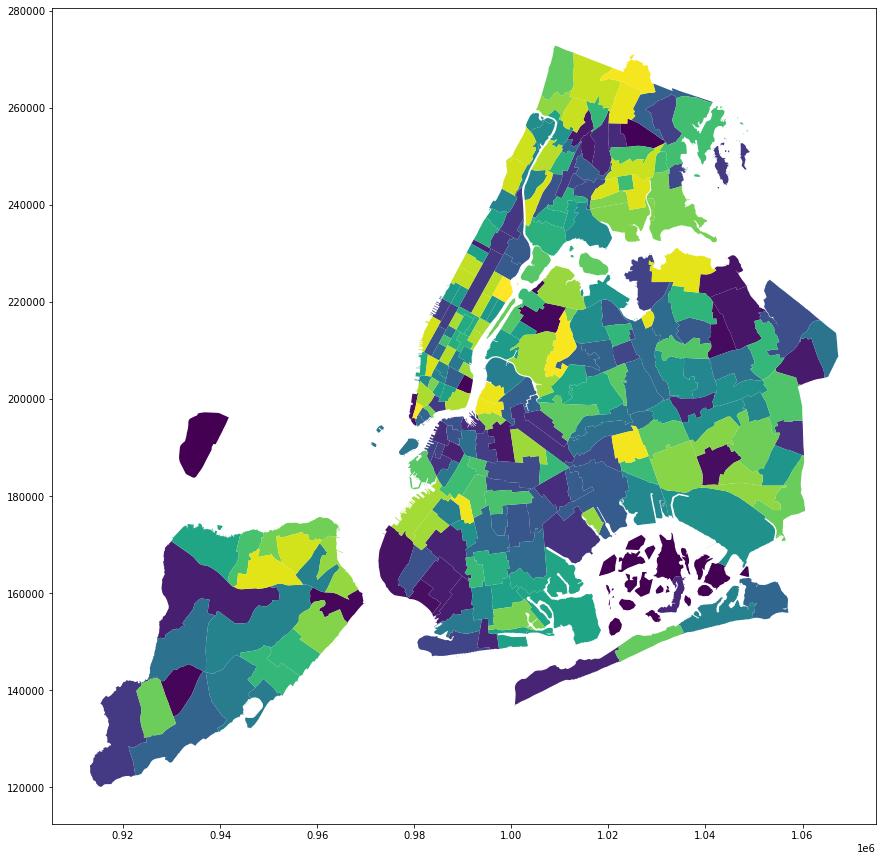

In [13]:
gdf.plot('LocationID', figsize=(15,15))

Odfiltrujmy sam Manhattan (bo tylko tam są interesujące nas strefy).

In [14]:
gdf['yellow'] = gdf['LocationID'].isin(yellow_zones)

In [15]:
gdf.head()

OBJECTID  Shape_Leng  Shape_Area                     zone  LocationID  \
0         1    0.116357    0.000782           Newark Airport           1   
1         2    0.433470    0.004866              Jamaica Bay           2   
2         3    0.084341    0.000314  Allerton/Pelham Gardens           3   
3         4    0.043567    0.000112            Alphabet City           4   
4         5    0.092146    0.000498            Arden Heights           5   

         borough                                           geometry  yellow  
0            EWR  POLYGON ((933100.918 192536.086, 933091.011 19...   False  
1         Queens  MULTIPOLYGON (((1033269.244 172126.008, 103343...   False  
2          Bronx  POLYGON ((1026308.770 256767.698, 1026495.593 ...   False  
3      Manhattan  POLYGON ((992073.467 203714.076, 992068.667 20...    True  
4  Staten Island  POLYGON ((935843.310 144283.336, 936046.565 14...   False

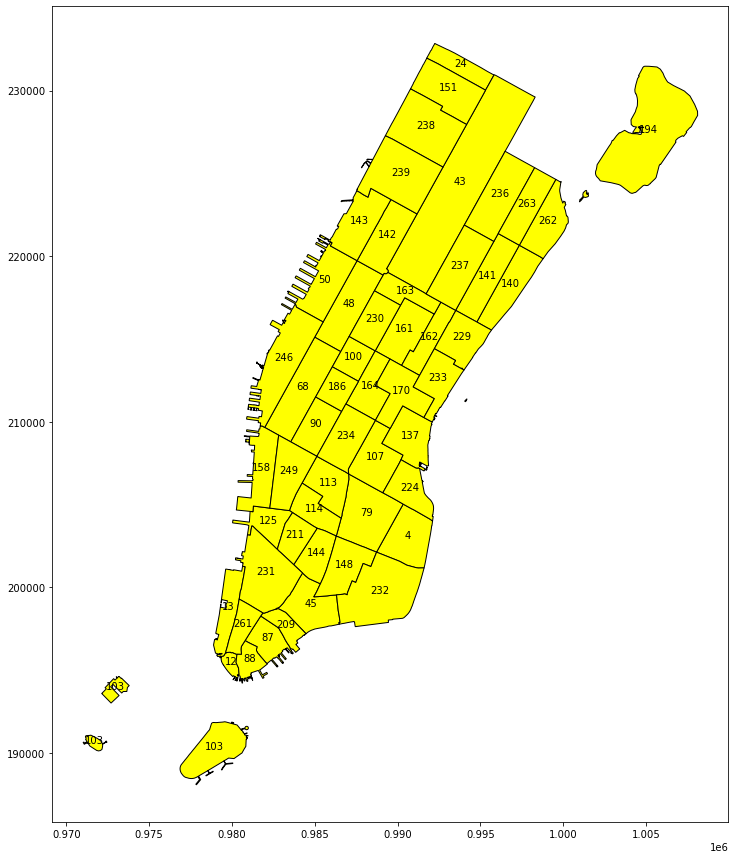

In [16]:
base = gdf[gdf['yellow'] == True].plot(color='yellow', edgecolor='black', figsize=(15,15))
gdf[gdf['yellow'] == True].apply(lambda x: base.annotate(text=x['LocationID'], xy=x.geometry.centroid.coords[0], ha='center'), axis=1);

Ciekawe obserwacje:
1. 3 wysepki na południowym-zachodze wg user guide nie są "żółtą strefą", ale nie będziemy z tym dyskutować
1. te same 3 wysepki mają przypisany w shapefile `LocationID` = `103`, ale z mapki ze strony wiemy, że mają 3 różne IDki

Obejrzyjmy jak wygląda ta sama mapa z `OBJECTID`

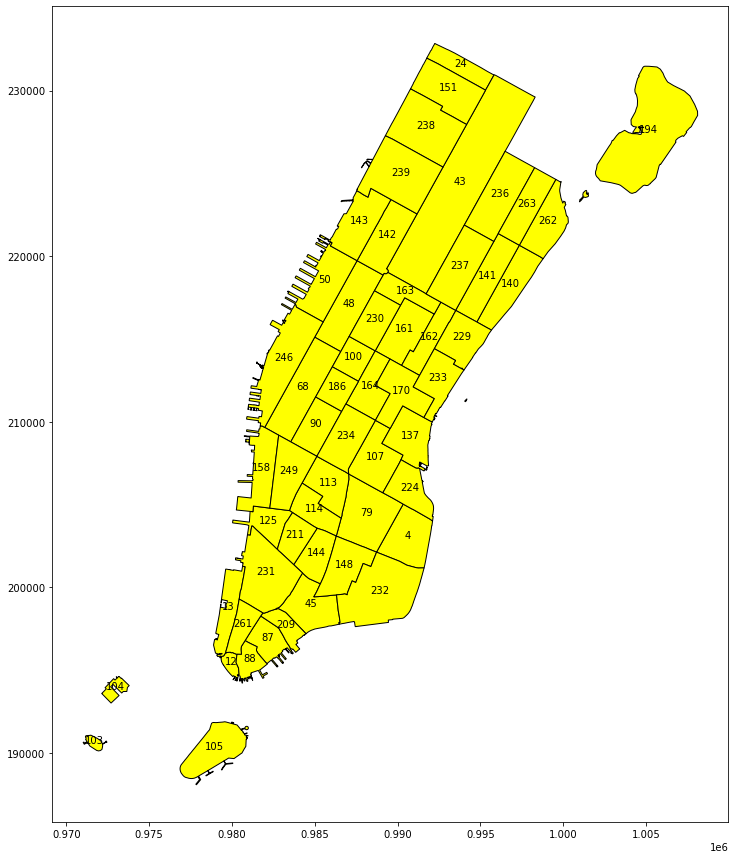

In [17]:
base = gdf[gdf['yellow'] == True].plot(color='yellow', edgecolor='black', figsize=(15,15))
gdf[gdf['yellow'] == True].apply(lambda x: base.annotate(text=x['OBJECTID'], xy=x.geometry.centroid.coords[0], ha='center'), axis=1);

Te 3 kłopotliwe wyspy mają teraz takie IDki jak na mapie. Popatrzmy jak wyglądają one w obu ramkach.

In [18]:
gdf[gdf['LocationID'] == 103]

OBJECTID  Shape_Leng  Shape_Area  \
102       103    0.014306    0.000006   
103       104    0.021221    0.000012   
104       105    0.077425    0.000369   

                                              zone  LocationID    borough  \
102  Governor's Island/Ellis Island/Liberty Island         103  Manhattan   
103  Governor's Island/Ellis Island/Liberty Island         103  Manhattan   
104  Governor's Island/Ellis Island/Liberty Island         103  Manhattan   

                                              geometry  yellow  
102  POLYGON ((972079.575 190732.429, 972184.766 19...    True  
103  POLYGON ((973172.666 194632.348, 973310.630 19...    True  
104  POLYGON ((979605.759 191880.575, 979978.435 19...    True

In [19]:
zones[zones['LocationID'].isin([103, 104, 105])]

LocationID    Borough                                           Zone  \
102         103  Manhattan  Governor's Island/Ellis Island/Liberty Island   
103         104  Manhattan  Governor's Island/Ellis Island/Liberty Island   
104         105  Manhattan  Governor's Island/Ellis Island/Liberty Island   

    service_zone  
102  Yellow Zone  
103  Yellow Zone  
104  Yellow Zone

Sprawdźmy filtrowanie po `OBJECTID`

In [20]:
gdf['yellow_objectid'] = gdf['OBJECTID'].isin(yellow_zones)

In [21]:
gdf[gdf['yellow_objectid'] != gdf['yellow']]

Empty GeoDataFrame
Columns: [OBJECTID, Shape_Leng, Shape_Area, zone, LocationID, borough, geometry, yellow, yellow_objectid]
Index: []

In [22]:
gdf[gdf['yellow_objectid'] == gdf['yellow']]

OBJECTID  Shape_Leng  Shape_Area                     zone  LocationID  \
0           1    0.116357    0.000782           Newark Airport           1   
1           2    0.433470    0.004866              Jamaica Bay           2   
2           3    0.084341    0.000314  Allerton/Pelham Gardens           3   
3           4    0.043567    0.000112            Alphabet City           4   
4           5    0.092146    0.000498            Arden Heights           5   
..        ...         ...         ...                      ...         ...   
258       259    0.126750    0.000395       Woodlawn/Wakefield         259   
259       260    0.133514    0.000422                 Woodside         260   
260       261    0.027120    0.000034       World Trade Center         261   
261       262    0.049064    0.000122           Yorkville East         262   
262       263    0.037017    0.000066           Yorkville West         263   

           borough                                           geometry  yellow  \
0              EWR  POLYGON ((933100.918 192536.086, 933091.011 19...   False   
1           Queens  MULTIPOLYGON (((1033269.244 172126.008, 103343...   False   
2            Bronx  POLYGON ((1026308.770 256767.698, 1026495.593 ...   False   
3        Manhattan  POLYGON ((992073.467 203714.076, 992068.667 20...    True   
4    Staten Island  POLYGON ((935843.310 144283.336, 936046.565 14...   False   
..             ...                                                ...     ...   
258          Bronx  POLYGON ((1025414.782 270986.139, 1025138.624 ...   False   
259         Queens  POLYGON ((1011466.966 216463.005, 1011545.889 ...   False   
260      Manhattan  POLYGON ((980555.204 196138.486, 980570.792 19...    True   
261      Manhattan  MULTIPOLYGON (((999804.795 224498.527, 999824....    True   
262      Manhattan  POLYGON ((997493.323 220912.386, 997355.264 22...    True   

     yellow_objectid  
0              False  
1              False  
2              False  
3               True  
4              False  
..               ...  
258            False  
259            False  
260             True  
261             True  
262             True  

[263 rows x 9 columns]

Mimo tych rozbieżności w kolumnach `OBJECTID` i `LocationId` wygląda na to, że możemy filtrować żółte strefy po jednej i drugiej kolumnie - labelki na wizualizacjach lepiej chyba brać z `OBJECTID` (zakładając, że na koncu klientowi chcielibyśmy pokazywać przewidziany popyt na mapie, razem z labelkami stref).

W danych na szczęście jest tylko jedna kolumna po której możemy filtrować - `PULocationID`.

Popatrzmy jeszcze jak wygląda obszar, który nas interesuje w porónaniu do całego NYC.

<AxesSubplot:>

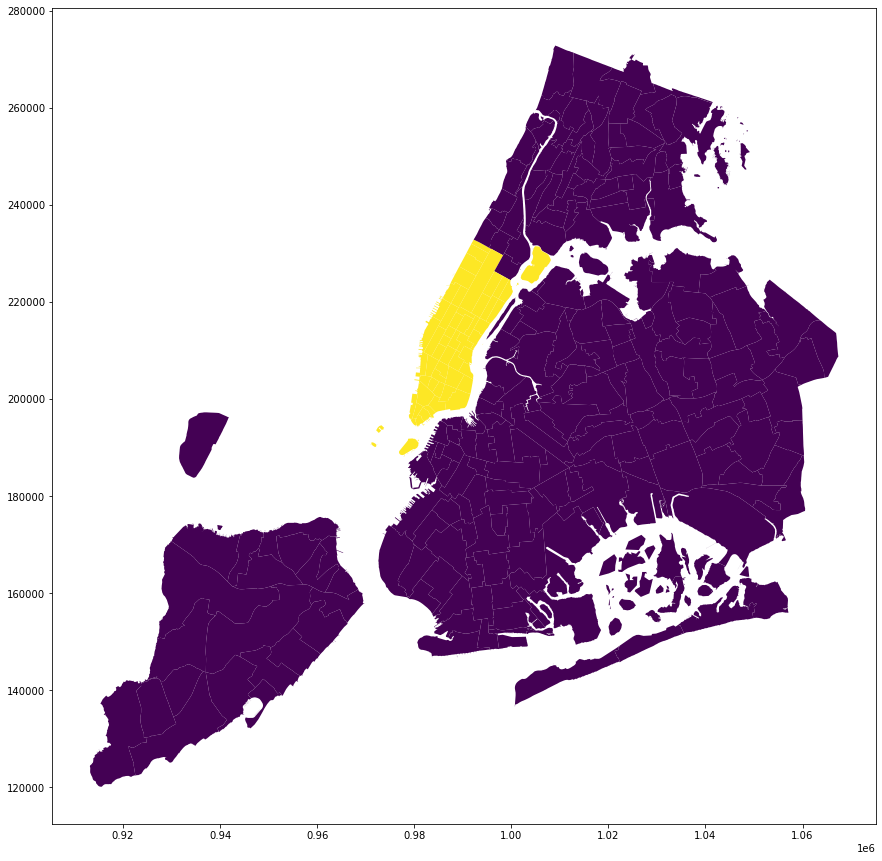

In [23]:
gdf.plot('yellow', figsize=(15,15))

## Ściąganięcie danych

Dane ściągnęliśmy wywołując w naszym katalogu roboczym skrypt `dl_data.py`.

## Dane pre-COVID - styczeń-luty 2021

Najpierw sprawdzimy sobie na "normalnych" danych czy nasze podejście do problemu jako przewidywania szeregów czasowych ma w ogóle sens.
* Oczyścimy dane jedynie w minimalnym stopniu, 
* sprawdzimy, które z interesujących nas stref miały najwięcej rozpoczynanych w nich przejazdów,
* zobaczymy jak wygląda wykres w rozdzielczości dziennej dla najpopularniejszej strefy
* i spróbujemy zrobić forecast przy użyciu Propheta dla tej strefy.

Najpierw załadujemy dane - ponieważ są stosunkowo małe (koło 1,1 GB) na razie spróbujemy podziałać na czystym `pandas`ie.

In [24]:
# df = pd.read_csv(DATA_FOLDER / 'yellow_tripdata_2020-01.csv', parse_dates=[1, 2], 
#                  dtype={'VendorID': 'category', 
#                         'RatecodeID': 'category', 
#                         'payment_type': 'category', 
#                         'store_and_fwd_flag': 'category'})

In [25]:
df = pd.read_csv(DATA_FOLDER / 'yellow_tripdata_2020-01.csv', parse_dates=[1, 2], dtype={'store_and_fwd_flag': 'category'})

In [26]:
df.head()

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0       1.0  2020-01-01 00:28:15   2020-01-01 00:33:03              1.0   
1       1.0  2020-01-01 00:35:39   2020-01-01 00:43:04              1.0   
2       1.0  2020-01-01 00:47:41   2020-01-01 00:53:52              1.0   
3       1.0  2020-01-01 00:55:23   2020-01-01 01:00:14              1.0   
4       2.0  2020-01-01 00:01:58   2020-01-01 00:04:16              1.0   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0            1.2         1.0                  N           238           239   
1            1.2         1.0                  N           239           238   
2            0.6         1.0                  N           238           238   
3            0.8         1.0                  N           238           151   
4            0.0         1.0                  N           193           193   

   payment_type  fare_amount  extra  mta_tax  tip_amount  tolls_amount  \
0           1.0          6.0    3.0      0.5        1.47           0.0   
1           1.0          7.0    3.0      0.5        1.50           0.0   
2           1.0          6.0    3.0      0.5        1.00           0.0   
3           1.0          5.5    0.5      0.5        1.36           0.0   
4           2.0          3.5    0.5      0.5        0.00           0.0   

   improvement_surcharge  total_amount  congestion_surcharge  
0                    0.3         11.27                   2.5  
1                    0.3         12.30                   2.5  
2                    0.3         10.80                   2.5  
3                    0.3          8.16                   0.0  
4                    0.3          4.80                   0.0

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6405008 entries, 0 to 6405007
Data columns (total 18 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               float64       
 1   tpep_pickup_datetime   datetime64[ns]
 2   tpep_dropoff_datetime  datetime64[ns]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     category      
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           float64       
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
dtypes: category(1), dateti

6,4 G rekordów w samym styczniu.

Co ciekawe mamy dodatkową kolumnę `congestion_surcharge`, o której nic nie wiemy (nie było jej w słowniku danych, prawdopodobine to ta opłata https://www.tax.ny.gov/bus/cs/csidx.htm - co ciekawe w "naszej" żółtej strefie są obszary, które nie pobierają tej opłaty), ale na nasze potrzeby wystarczy, że użyjemy jej do podczyszczenia datasetu.

Popatrzmy najpierw jak rozkłada się ilość przejazdów per dzień.

In [28]:
import seaborn as sns

<AxesSubplot:xlabel='tpep_pickup_datetime'>

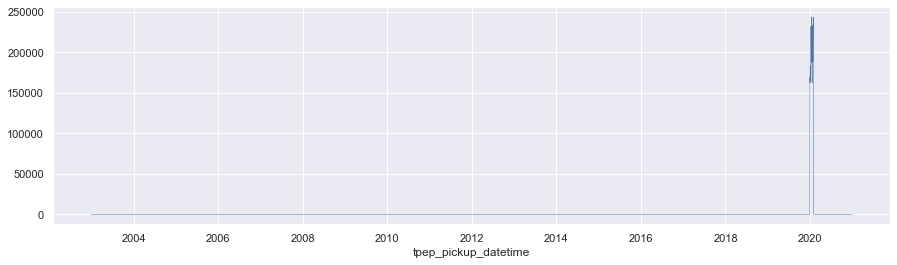

In [29]:
sns.set(rc={'figure.figsize':(15, 4)})
df.groupby([df['tpep_pickup_datetime'].dt.date])['PULocationID'].count().plot(linewidth=0.5)

Ograniczmy sobie zakres dat do prawidłowych (już widać, że daty są do czyszczenia, ale zrobimy to później).

<AxesSubplot:xlabel='tpep_pickup_datetime'>

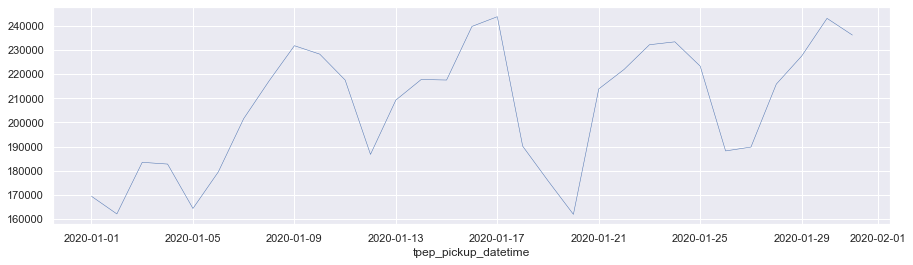

In [30]:
sns.set(rc={'figure.figsize':(15, 4)})
df[(df['tpep_pickup_datetime'] >= '2020-01-01') & (df['tpep_pickup_datetime'] < '2020-02-01')].\
groupby([df['tpep_pickup_datetime'].dt.date])['PULocationID'].count().plot(linewidth=0.5)

Minimalnie oczyścimy sobie dane, sprawdźmy najpierw czy są w nich jakieś NaNy.

In [31]:
df.isnull().any()

VendorID                  True
tpep_pickup_datetime     False
tpep_dropoff_datetime    False
passenger_count           True
trip_distance            False
RatecodeID                True
store_and_fwd_flag        True
PULocationID             False
DOLocationID             False
payment_type              True
fare_amount              False
extra                    False
mta_tax                  False
tip_amount               False
tolls_amount             False
improvement_surcharge    False
total_amount             False
congestion_surcharge     False
dtype: bool

NaNy w `payment_type` moglibyśmy uznać za `5` (`Unknown`), ale przy tej ilości danych i na razie bardzo prostym "PoC" nie będziemy się nad tym zastanawiać - usuniemy wszytskie rekordy z brakującymi wartościami. Ogólnie wykonamy proste czyszczenie danych z pliku opisane poniżej.

Ponieważ za chwilę załadujemy drugi plik CSV procedurę czyszczenia zamkniemy sobie w prostą funkcję, która będzie:
1. usuwała rekordy z NaNami
1. usuwała rekordy z `tpep_pickup_datetime` leżącym poza miesiącem dla danego pliku
1. usuwała rekordy z `tpep_dropoff_datetime` leżącymi wcześniej niż pierwszy dzień danego miesiąca i dalej niż pierwszy dzień następnego miesiąca
1. odfiltrowywała tylko te rekordy, których pickup location `PULocationID` jest w strefie żółtej `yellow_zones`
    1. Zastanawiałem się nad usunięciem rekordów z `DOLocationID` (strefa, w której zakończyła się podróż) nie znajdującymi się w słowniku stref, ale co jeżeli taksówka zakończyła kurs poza NYC? Zgaduję, że takie przypadki to prawdopodobnie i tak NaNy (więc i tak zostaną usunięte), ale nie mam tego jak sprawdzić. Na razie zostawiam - w przypadku pełnego datasetu i tak będziemy odfiltrowywać jakieś ouliery, więc tego typu kursy prawdopodobnie i tak w końcu wypadną przed ostatecznym modelowaniem.
1. usuwała na postawie kolumny `VendorID` rekordy z wartościami różnymi od `1` i `2` (takie jak w słowniku danych)
1. usuwała na podstawie kolumny `RatecodeID` rekordy z wartościami poza zakresem 1-6 (taki jak w słowniku danych)
1. usuwała na podstawie kolumny `payment_type` rekordy o wartościach `3` (`No charge`), `4` (`Dispute`), `6` (`Voided trip`) (innymi słowy zostawiamy wartości `1`, `2`, i `5`)
1. usuwała na podstawie kolumny `store_and_fwd_flag` rekordy z wartościami innymi niż `N` lub `Y` (takie jak w słowniku danych)
1. zamieniała typ danych na int, w kolumnach, które powinny mieć tylko inty po usunięciu NaNów i niepasujących wartości (`passenger_count`, `VendorID`, `RatecodeID`, `payment_type`)
1. usuwała rekordy z wartościami mniejszymi-równymi `0` dla kolumn dla których nie ma to sensu
    1. ilości pasażerów `passenger_count`
    1. długości podróży `trip_distance`
    1. oplacie naliczonej przez taksometr `fare_amount`
    1. całkowitej kwocie do zapłacenia `total_amount`
1. usuwała rekordy z wartościami mniejszymi od `0` dla kolumn dla których nie ma to sensu
    1. dodatkowe nałożone opłaty `extra`
    1. podatek MTA `mta_tax`
    1. kwota napiwku `tip_amount`
    1. kwota opłat drogowych `tolls_amount`
    1. dodatkowa opłata `improvement_surcharge`
    1. opłata "korkowa" `congestion_surcharge`
1. zamieniała typ danych na dane kateogryczne w kolumnach, w których ma to sens (`PULocationID`, `DOLocationID`, `VendorID`, `RatecodeID`, `payment_type`)
1. usuwała rekordy gdzie `tpep_dropoff_datetime` <= `tpep_pickup_datetime`
1. usuwała zduplikowane rekordy
1. na końcu zresetuje index

Zobaczymy ile % rekordów zostanie po tej operacji.

In [16]:
from datetime import datetime
import numpy as np

In [33]:
def simple_clean(df: pd.DataFrame, year: int, month: int, good_zones: pd.Series) -> pd.DataFrame:
    start_date, end_date = datetime(year, month, 1), datetime(year, month+1, 1)
    df = df.dropna()
    df = df[(df['tpep_pickup_datetime'] >= start_date) & (df['tpep_pickup_datetime'] < end_date)]
    df = df[(df['tpep_dropoff_datetime'] >= start_date) & (df['tpep_dropoff_datetime'] < end_date.replace(day=2))]
    df = df[df['PULocationID'].isin(good_zones)]
    df = df[df['VendorID'].isin(np.array([1, 2]))]
    df = df[df['RatecodeID'].isin(np.arange(1, 7))]
    df = df[df['payment_type'].isin(np.array([1, 2, 5]))]
    df = df[df['store_and_fwd_flag'].isin(['Y', 'N'])]
    df = df.astype({'passenger_count': 'int',
                   'VendorID': 'int',
                   'RatecodeID': 'int',
                   'payment_type': 'int'})
    df = df[df[['passenger_count', 'trip_distance', 'fare_amount', 'total_amount']].gt(0).all(axis=1)]
    df = df[df[['extra', 'mta_tax', 'tip_amount', 'tolls_amount', 
                'improvement_surcharge', 'congestion_surcharge']].ge(0).all(axis=1)]
    df = df[df['tpep_dropoff_datetime'] > df['tpep_pickup_datetime']]
    df = df.drop_duplicates()
    df = df.reset_index(drop=True)
    return df

Korzystamy z naszej funkcji

In [34]:
df = simple_clean(df=df, year=2020, month=1, good_zones=yellow_zones)

Popatrzmy jak teraz wygląda nasza ramka:

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5490523 entries, 0 to 5490522
Data columns (total 18 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int32         
 1   tpep_pickup_datetime   datetime64[ns]
 2   tpep_dropoff_datetime  datetime64[ns]
 3   passenger_count        int32         
 4   trip_distance          float64       
 5   RatecodeID             int32         
 6   store_and_fwd_flag     category      
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int32         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
dtypes: category(1), dateti

In [36]:
100 - 5.49 / 6.4 * 100

14.21875

Zniknęło około 14.2 % danych - popatrzmy czy wpłynęło to na rozkład przejazdów per dzień.

<AxesSubplot:xlabel='tpep_pickup_datetime'>

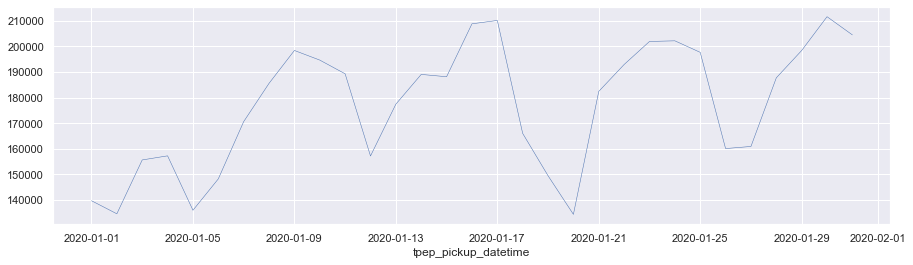

In [37]:
df.groupby([df['tpep_pickup_datetime'].dt.date])['PULocationID'].count().plot(linewidth=0.5)

Na pierwszy rzut oka nasze czyszczenie nie zaburza rozkładu - na razie w ciemno zakładamy, że przy drugim miesiącu też tak będzie :)

Ładujemy luty 2021, czyścimy i dołączmy do naszych istniejących danych.

In [38]:
temp_df = df.copy()

In [39]:
df = pd.read_csv(DATA_FOLDER / 'yellow_tripdata_2020-02.csv', parse_dates=[1, 2], dtype={'store_and_fwd_flag': 'category'})

In [40]:
df.head()

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0       1.0  2020-02-01 00:17:35   2020-02-01 00:30:32              1.0   
1       1.0  2020-02-01 00:32:47   2020-02-01 01:05:36              1.0   
2       1.0  2020-02-01 00:31:44   2020-02-01 00:43:28              1.0   
3       2.0  2020-02-01 00:07:35   2020-02-01 00:31:39              1.0   
4       2.0  2020-02-01 00:51:43   2020-02-01 01:01:29              1.0   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0           2.60         1.0                  N           145             7   
1           4.80         1.0                  N            45            61   
2           3.20         1.0                  N           186           140   
3           4.38         1.0                  N           144           140   
4           2.28         1.0                  N           238           152   

   payment_type  fare_amount  extra  mta_tax  tip_amount  tolls_amount  \
0           1.0         11.0    0.5      0.5        2.45           0.0   
1           1.0         21.5    3.0      0.5        6.30           0.0   
2           1.0         11.0    3.0      0.5        1.00           0.0   
3           1.0         18.0    0.5      0.5        3.00           0.0   
4           2.0          9.5    0.5      0.5        0.00           0.0   

   improvement_surcharge  total_amount  congestion_surcharge  
0                    0.3         14.75                   0.0  
1                    0.3         31.60                   2.5  
2                    0.3         15.80                   2.5  
3                    0.3         24.80                   2.5  
4                    0.3         10.80                   0.0

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6299354 entries, 0 to 6299353
Data columns (total 18 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               float64       
 1   tpep_pickup_datetime   datetime64[ns]
 2   tpep_dropoff_datetime  datetime64[ns]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     category      
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           float64       
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
dtypes: category(1), dateti

<AxesSubplot:xlabel='tpep_pickup_datetime'>

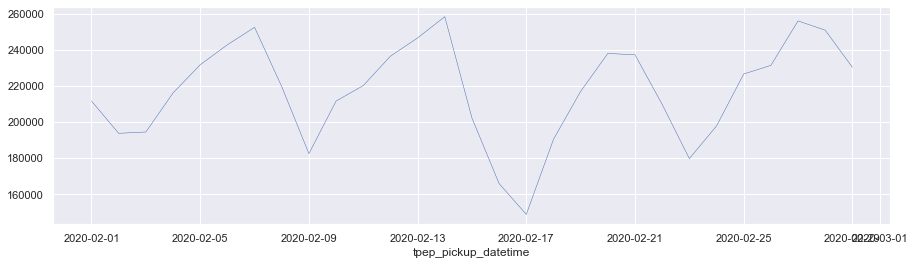

In [42]:
df[(df['tpep_pickup_datetime'] >= '2020-02-01') & (df['tpep_pickup_datetime'] < '2020-03-01')].\
groupby([df['tpep_pickup_datetime'].dt.date])['PULocationID'].count().plot(linewidth=0.5)

In [43]:
df = simple_clean(df=df, year=2020, month=2, good_zones=yellow_zones)

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5438318 entries, 0 to 5438317
Data columns (total 18 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int32         
 1   tpep_pickup_datetime   datetime64[ns]
 2   tpep_dropoff_datetime  datetime64[ns]
 3   passenger_count        int32         
 4   trip_distance          float64       
 5   RatecodeID             int32         
 6   store_and_fwd_flag     category      
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int32         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
dtypes: category(1), dateti

<AxesSubplot:xlabel='tpep_pickup_datetime'>

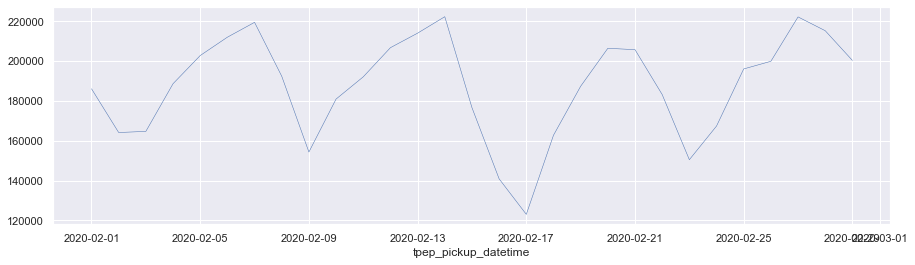

In [45]:
df.groupby([df['tpep_pickup_datetime'].dt.date])['PULocationID'].count().plot(linewidth=0.5)

In [46]:
100 - 5.4 / 6.3 * 100

14.285714285714278

Znowu usunęliśmy koło 14,3% danych, ale nie zaburzając rozkładu w czasie.

Połączmy sobie obie ramki i popatrzmy na szereg czasowy.

In [47]:
df = pd.concat([temp_df, df])

In [48]:
df.head()

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         1  2020-01-01 00:28:15   2020-01-01 00:33:03                1   
1         1  2020-01-01 00:35:39   2020-01-01 00:43:04                1   
2         1  2020-01-01 00:47:41   2020-01-01 00:53:52                1   
3         1  2020-01-01 00:55:23   2020-01-01 01:00:14                1   
4         1  2020-01-01 00:29:01   2020-01-01 00:40:28                2   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0            1.2           1                  N           238           239   
1            1.2           1                  N           239           238   
2            0.6           1                  N           238           238   
3            0.8           1                  N           238           151   
4            0.7           1                  N           246            48   

   payment_type  fare_amount  extra  mta_tax  tip_amount  tolls_amount  \
0             1          6.0    3.0      0.5        1.47           0.0   
1             1          7.0    3.0      0.5        1.50           0.0   
2             1          6.0    3.0      0.5        1.00           0.0   
3             1          5.5    0.5      0.5        1.36           0.0   
4             1          8.0    3.0      0.5        2.35           0.0   

   improvement_surcharge  total_amount  congestion_surcharge  
0                    0.3         11.27                   2.5  
1                    0.3         12.30                   2.5  
2                    0.3         10.80                   2.5  
3                    0.3          8.16                   0.0  
4                    0.3         14.15                   2.5

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10928841 entries, 0 to 5438317
Data columns (total 18 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int32         
 1   tpep_pickup_datetime   datetime64[ns]
 2   tpep_dropoff_datetime  datetime64[ns]
 3   passenger_count        int32         
 4   trip_distance          float64       
 5   RatecodeID             int32         
 6   store_and_fwd_flag     category      
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int32         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
dtypes: category(1), datet

<AxesSubplot:xlabel='tpep_pickup_datetime'>

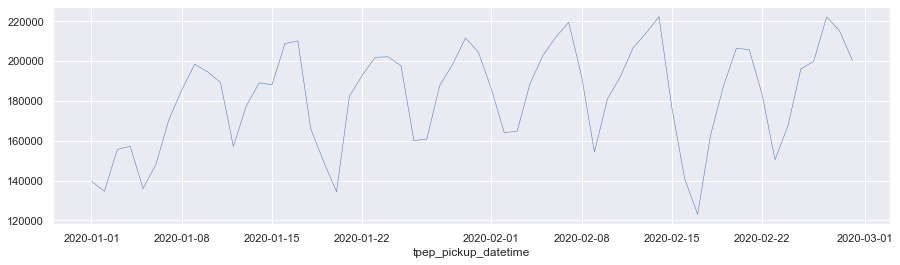

In [50]:
df.groupby([df['tpep_pickup_datetime'].dt.date])['PULocationID'].count().plot(linewidth=0.5)

Popatrzmy, która strefa jest najpczęstsza w naszej nowej ramce.

In [51]:
df['PULocationID'].value_counts()

237    551959
161    542433
236    515774
162    453773
230    438629
186    437573
170    372735
142    370771
48     370214
234    369110
163    342425
239    329607
79     311952
141    300264
68     290516
164    277004
107    274345
238    254768
249    243501
100    238493
229    238480
263    236925
140    234560
246    220486
90     210386
231    199516
113    186592
43     181005
262    164304
114    157601
148    152224
233    151450
143    146004
137    139351
158    119877
144    115884
151    108934
211     98273
13      98142
50      94594
87      77330
261     65514
125     64259
88      40768
24      36158
209     22595
224     22139
45      20932
4       19494
232     15113
12       3492
194       608
105         5
Name: PULocationID, dtype: int64

Weźmiemy tylko strefę 237, żeby sprawdzić czy jej szereg też wygląda tak "ładnie".

In [253]:
df_237 = df.loc[df['PULocationID'] == 237, ['tpep_pickup_datetime', 'PULocationID']]

In [53]:
df_237.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 551959 entries, 18 to 5438238
Data columns (total 2 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   tpep_pickup_datetime  551959 non-null  datetime64[ns]
 1   PULocationID          551959 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 12.6 MB


<AxesSubplot:xlabel='tpep_pickup_datetime'>

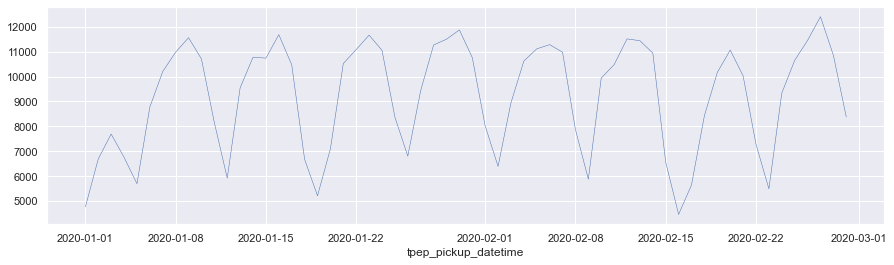

In [54]:
df_237.groupby([df_237['tpep_pickup_datetime'].dt.date])['PULocationID'].count().plot(linewidth=0.5)

Bardziej praktyczna z punktu widenia biznesowego będzie rozdzielczość data-godzina

<AxesSubplot:xlabel='tpep_pickup_datetime,tpep_pickup_datetime'>

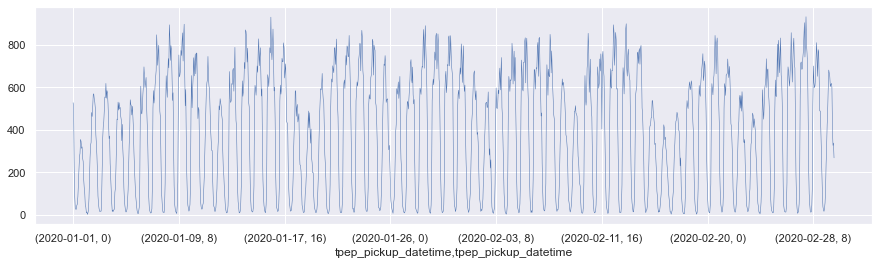

In [55]:
df_237.groupby([df_237['tpep_pickup_datetime'].dt.date, df_237['tpep_pickup_datetime'].dt.hour])['PULocationID'].count().plot(linewidth=0.5)

Nawet lepiej niż dla wszystkich stref.

Teraz w klasycznym przewidywaniu szeregów czasowych np. przy użyciu ARIMA powinniśmy przeanalizować nasz szereg, żeby dobrać odpowiednie parametry (i w ogóle stwierdzić, czy nadaje się do przewidywania) patrząc i interpretując ACF i PACF itd.

Zamiast tego skorzystamy z Propheta, który automagicznie zrobi za nas praktycznie wszystko - zwróćmy uwagę, że wykonaliśmy tylko minimalne czyszczenie danych właściwie na podstawie samego słownika, praktycznie bez EDA :) (dla całego datasetu popatrzymy sobie trochę dokładniej na te dane, ale teraz chemy przetestować możliwości Propheta w "normalnych" warunkach pre-COVID).

In [198]:
df_237.head()

tpep_pickup_datetime  PULocationID
18  2020-01-01 00:48:23           237
41  2020-01-01 00:43:33           237
42  2020-01-01 00:05:31           237
53  2020-01-01 00:20:37           237
61  2020-01-01 00:20:03           237

Przygotujmy najpierw dane tak, żeby miały rozdzielczość godzinową (ilość kursów z naszej strefy `237` na data-godzina) i były czytelne dla Propheta zgodnie z dokumentacją https://facebook.github.io/prophet/docs/quick_start.html#python-api

Dodatkowo ustawimy minimalną wartość przejazdów na 1e-6 (większe od 0 bo będziemy liczyć MAPE dla predykcji i nie chcemy błędu dzielenia przez 0) https://facebook.github.io/prophet/docs/saturating_forecasts.html#saturating-minimum

Żeby to zrobić musimy też ustalić maksymalną możliwość wartość - ustalimy ją sobie na poziomie max() * 1.1 zakładając 10% możliwego wzrostu w przewidywanym okresie (olbrzymi naddatek).

Zamkniemy to sobie w funkcji, może przyda się później przy całym datasecie.

In [219]:
from typing import Tuple

In [251]:
def prepare_for_prophet(df: pd.DataFrame, cap_mult: float, floor: float) -> Tuple[pd.DataFrame, float]:
    df = df.groupby([df['tpep_pickup_datetime'].dt.date, df['tpep_pickup_datetime'].dt.hour]).count()
    df.index = df.index.rename(['date', 'hour'])
    df = df.reset_index()
    df['ds'] = pd.to_datetime(df['date']) + pd.to_timedelta(df['hour'], unit='h')
    df = df[['ds', 'PULocationID']]
    df = df.rename(columns={'PULocationID': 'y'})
#     cap = np.ceil(df['y'].max() * (1 + cap_mult)).astype(int)
    cap = df['y'].max() * (1 + cap_mult)
    df['cap'] = cap  # we have to specify max cap to be able to set floor
    df['floor'] = floor  # can't have less than 0 journeys, so we need to specify floor
    return df, cap

In [264]:
floor = 1e-6

In [254]:
df_237, cap = prepare_for_prophet(df=df_237, cap_mult=0.1, floor=floor)

In [255]:
cap

1025.2

In [256]:
df_237

ds    y     cap     floor
0    2020-01-01 00:00:00  527  1025.2  0.000001
1    2020-01-01 01:00:00  496  1025.2  0.000001
2    2020-01-01 02:00:00  212  1025.2  0.000001
3    2020-01-01 03:00:00   88  1025.2  0.000001
4    2020-01-01 04:00:00   31  1025.2  0.000001
...                  ...  ...     ...       ...
1435 2020-02-29 19:00:00  600  1025.2  0.000001
1436 2020-02-29 20:00:00  409  1025.2  0.000001
1437 2020-02-29 21:00:00  326  1025.2  0.000001
1438 2020-02-29 22:00:00  337  1025.2  0.000001
1439 2020-02-29 23:00:00  267  1025.2  0.000001

[1440 rows x 4 columns]

Dzielimy na zbiór treningowy i testowy - testowy to będzie ostatnie 7 dni.

In [257]:
split_date = '2020-02-23'
end_date = '2020-02-29'
train = df_237[df_237['ds'] < split_date]
test = df_237[df_237['ds'] >= split_date]

In [258]:
train

ds    y     cap     floor
0    2020-01-01 00:00:00  527  1025.2  0.000001
1    2020-01-01 01:00:00  496  1025.2  0.000001
2    2020-01-01 02:00:00  212  1025.2  0.000001
3    2020-01-01 03:00:00   88  1025.2  0.000001
4    2020-01-01 04:00:00   31  1025.2  0.000001
...                  ...  ...     ...       ...
1267 2020-02-22 19:00:00  478  1025.2  0.000001
1268 2020-02-22 20:00:00  346  1025.2  0.000001
1269 2020-02-22 21:00:00  338  1025.2  0.000001
1270 2020-02-22 22:00:00  354  1025.2  0.000001
1271 2020-02-22 23:00:00  240  1025.2  0.000001

[1272 rows x 4 columns]

In [259]:
test

ds    y     cap     floor
1272 2020-02-23 00:00:00  162  1025.2  0.000001
1273 2020-02-23 01:00:00   80  1025.2  0.000001
1274 2020-02-23 02:00:00   40  1025.2  0.000001
1275 2020-02-23 03:00:00   28  1025.2  0.000001
1276 2020-02-23 04:00:00   13  1025.2  0.000001
...                  ...  ...     ...       ...
1435 2020-02-29 19:00:00  600  1025.2  0.000001
1436 2020-02-29 20:00:00  409  1025.2  0.000001
1437 2020-02-29 21:00:00  326  1025.2  0.000001
1438 2020-02-29 22:00:00  337  1025.2  0.000001
1439 2020-02-29 23:00:00  267  1025.2  0.000001

[168 rows x 4 columns]

Tworzymy obiekt Prophet, nieco bardziej elastyczny niż przy domyślnych ustawieniach (bo nasze dane nie są dzienne tylko godzinowe).

* https://facebook.github.io/prophet/docs/trend_changepoints.html#adjusting-trend-flexibility
* https://facebook.github.io/prophet/docs/non-daily_data.html#sub-daily-data

In [260]:
from prophet import Prophet

In [261]:
m = Prophet(changepoint_prior_scale=0.01, growth='logistic')

Dodamy publiczne święta w USA.

In [262]:
m.add_country_holidays(country_name='US')

In [263]:
m.fit(train)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
C:\Docs\sentione\dev\anaconda\envs\kinesso\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


In [265]:
future = m.make_future_dataframe(periods=7*24, freq ='1h')
future['cap'] = cap
future['floor'] = floor

In [292]:
fcst = m.predict(future)

C:\Docs\sentione\dev\anaconda\envs\kinesso\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Docs\sentione\dev\anaconda\envs\kinesso\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


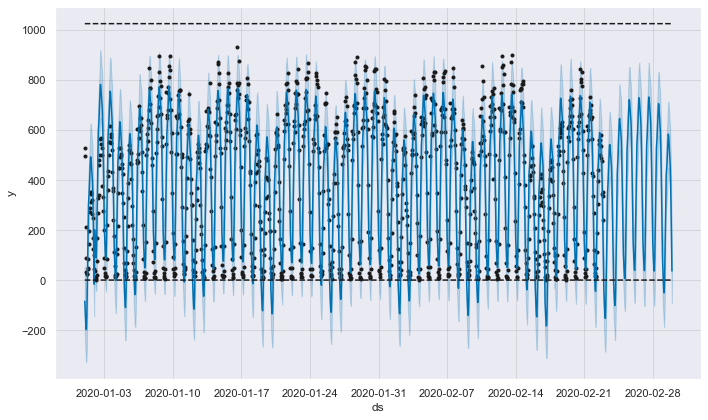

In [269]:
fig = m.plot(fcst)

<AxesSubplot:xlabel='ds'>

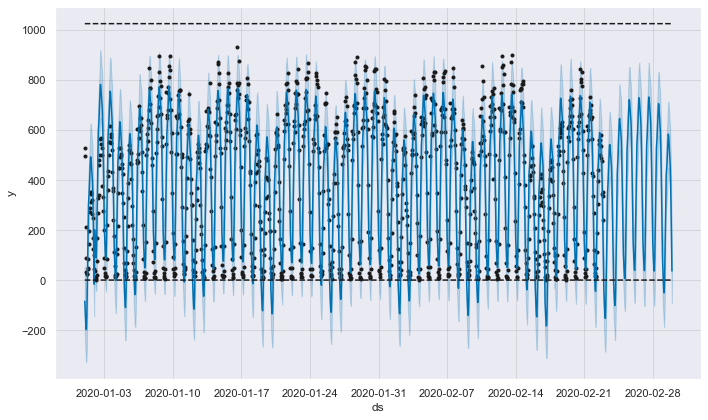

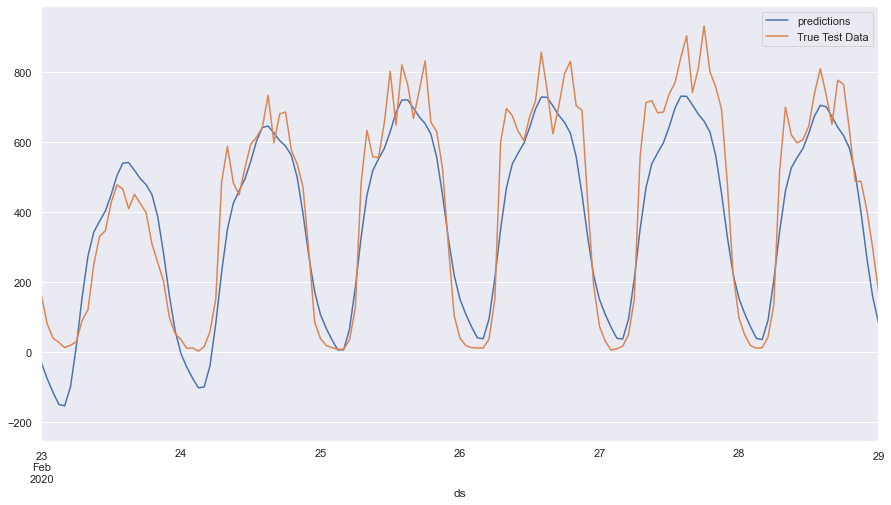

In [270]:
m.plot(fcst)
ax = fcst.plot(x='ds', y='yhat', legend=True, label='predictions', figsize=(15,8))
test.plot(x='ds', y='y', legend=True, label='True Test Data', ax=ax, xlim=(split_date, end_date))

Hmm, i tak przewiduje nam wartości mniejsze od zera co nie ma fizycznego sensu - za mało tutja wiem tutaj o tej bilbiotece, żeby to dobrze naprawić, więc po prostu ustawimy wartości mniejsze równe 0 na `floor`.

In [298]:
le_0_mask = fcst['yhat'].le(0)
fcst.loc[le_0_mask, 'yhat'] = floor

<AxesSubplot:xlabel='ds'>

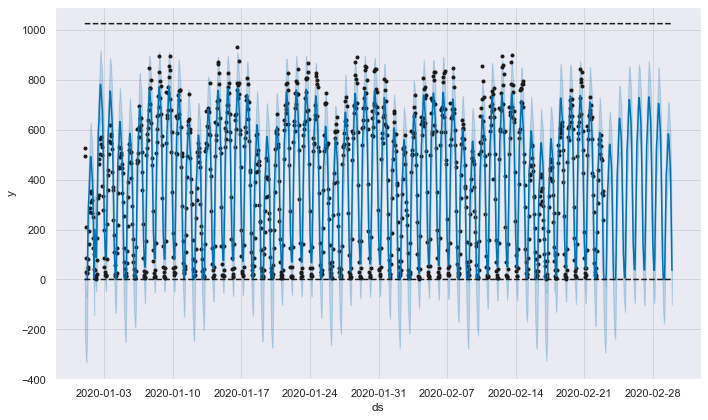

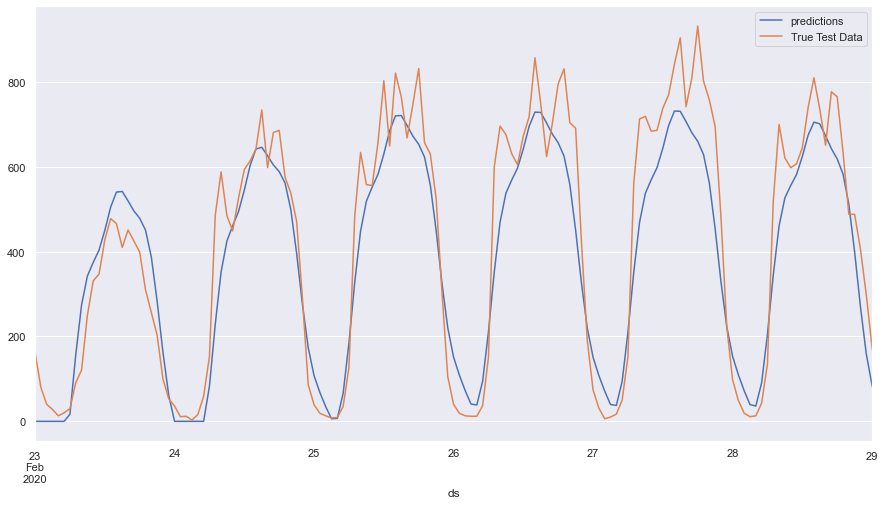

In [302]:
m.plot(fcst)
ax = fcst.plot(x='ds', y='yhat', legend=True, label='predictions', figsize=(15,8))
test.plot(x='ds', y='y', legend=True, label='True Test Data', ax=ax, xlim=(split_date, end_date))

Teraz ma to przynajmniej jakiś sens fizyczny :)

Popatrzmy na MAPE - najpierw policzymy go sobie sami dla predyckji i zbioru testowego.

In [303]:
from sklearn.metrics import mean_absolute_percentage_error

In [304]:
mean_absolute_percentage_error(test['y'], fcst[fcst['ds'] >= split_date]['yhat'])

0.6063621473390478

Jeżeli zinterpetujemy to jako % błędnych predyckji, to mam y accuracy na poziomie około 94% - not great, not terrible.

Biorąc pod uwagę, że praktycznie w ogóle nie obrabialiśmy naszych danych można to uznaż za całkiem ok wynik.

Patrząc po wykresie w godzinach szczytu model najczęściej niedoszacowuje popytu. Teraz moglibyśmy przejść do jego optymalizacji, ale nie ma to sensu, bo chcemy zobaczyć, czy podobnie będziemy mogli zamodelować potencjalny popyt dla całego datasetu.


Dodatkowo:
* można dodać do modelu dodatkowe regresory, ale trzeba mieć dla nich też przewidzianą wartość dla prognoz (można by dodać np. lockdown 1/0, dane o zachorowaniach, dane o ruchu lotniczmym do/z NYC itd.)
* można spróbować w samym szeregu czasowym dropnąć oultiery https://facebook.github.io/prophet/docs/outliers.html

Z ciekawości obejrzyjmy jak wyglądają komponenty naszego modelu.

C:\Docs\sentione\dev\anaconda\envs\kinesso\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Docs\sentione\dev\anaconda\envs\kinesso\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


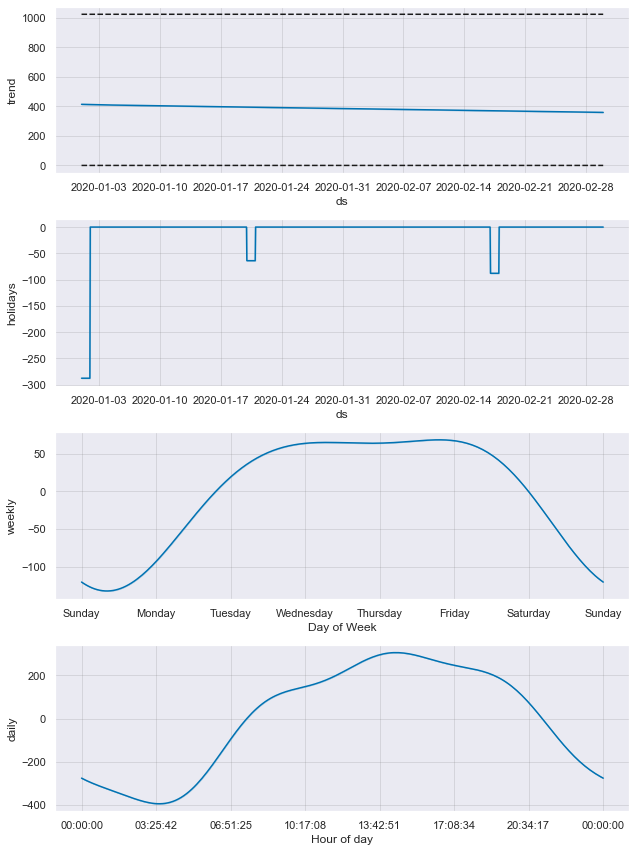

In [310]:
fig = m.plot_components(fcst)

Trend wygląda  na malejący, ciekawe.

Prophet ma wbudowaną cross walidację, której niektórzy używają do oceny modelu w tej bibliotece (bez podziału na zbiory treningowy i testowy). Zobaczmy jak wygląda MAPE wyliczone tą metodą przez Propheta (**nie będzie tutaj uwzględniona podmiana wartości mniejszych-równych `0` na `floor`**)

In [311]:
from prophet.diagnostics import cross_validation

In [312]:
df_cv = cross_validation(m, horizon = '7 days')

INFO:prophet:Making 8 forecasts with cutoffs between 2020-01-22 11:00:00 and 2020-02-15 23:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

C:\Docs\sentione\dev\anaconda\envs\kinesso\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Docs\sentione\dev\anaconda\envs\kinesso\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Docs\sentione\dev\anaconda\envs\kinesso\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Docs\sentione\dev\anaconda\envs\kinesso\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.con

In [323]:
df_cv

ds        yhat  yhat_lower  yhat_upper    y  \
0    2020-01-22 12:00:00  712.561768  561.415660  848.480933  749   
1    2020-01-22 13:00:00  764.864229  631.612006  898.352999  704   
2    2020-01-22 14:00:00  799.198446  650.227224  939.673484  795   
3    2020-01-22 15:00:00  801.735696  672.007276  947.706771  787   
4    2020-01-22 16:00:00  779.406023  634.316000  906.920530  743   
...                  ...         ...         ...         ...  ...   
1339 2020-02-22 19:00:00  479.549967  349.928283  614.941213  478   
1340 2020-02-22 20:00:00  407.973661  277.345691  551.184333  346   
1341 2020-02-22 21:00:00  294.841449  162.682198  429.676440  338   
1342 2020-02-22 22:00:00  164.947353   34.783829  307.951542  354   
1343 2020-02-22 23:00:00   54.435902  -74.526837  182.805809  240   

                  cutoff  
0    2020-01-22 11:00:00  
1    2020-01-22 11:00:00  
2    2020-01-22 11:00:00  
3    2020-01-22 11:00:00  
4    2020-01-22 11:00:00  
...                  ...  
1339 2020-02-15 23:00:00  
1340 2020-02-15 23:00:00  
1341 2020-02-15 23:00:00  
1342 2020-02-15 23:00:00  
1343 2020-02-15 23:00:00  

[1344 rows x 6 columns]

In [313]:
from prophet.diagnostics import performance_metrics

In [314]:
df_p = performance_metrics(df_cv)

In [318]:
df_p

horizon           mse        rmse         mae      mape     mdape  \
0   0 days 17:00:00  11119.769530  105.450318   90.701407  2.222364  0.219688   
1   0 days 18:00:00  11400.566753  106.773437   92.168857  2.270980  0.241046   
2   0 days 19:00:00  12037.375849  109.714976   94.928483  2.238021  0.280423   
3   0 days 20:00:00  12816.467872  113.209840   97.778481  2.120708  0.301417   
4   0 days 21:00:00  13192.507359  114.858641   99.234507  1.873191  0.302355   
..              ...           ...         ...         ...       ...       ...   
147 6 days 20:00:00  14174.176143  119.055349   98.847156  2.522248  0.259076   
148 6 days 21:00:00  13895.906552  117.880900   98.035146  2.413054  0.214313   
149 6 days 22:00:00  12820.067288  113.225736   94.339559  2.304831  0.198629   
150 6 days 23:00:00  13626.234166  116.731462   98.393897  2.292229  0.188550   
151 7 days 00:00:00  14403.594152  120.014975  101.188839  2.272275  0.199618   

        smape  coverage  
0    0.699524  0.742537  
1    0.678434  0.733209  
2    0.643142  0.708955  
3    0.602876  0.708955  
4    0.559771  0.708955  
..        ...       ...  
147  0.599408  0.695896  
148  0.543508  0.694030  
149  0.492518  0.710821  
150  0.487281  0.694030  
151  0.502805  0.671642  

[152 rows x 8 columns]

In [319]:
df_p['mape'].describe()

count    152.000000
mean       1.443142
std        0.639880
min        0.494643
25%        0.948991
50%        1.258866
75%        1.885099
max        2.783296
Name: mape, dtype: float64

In [316]:
from prophet.plot import plot_cross_validation_metric

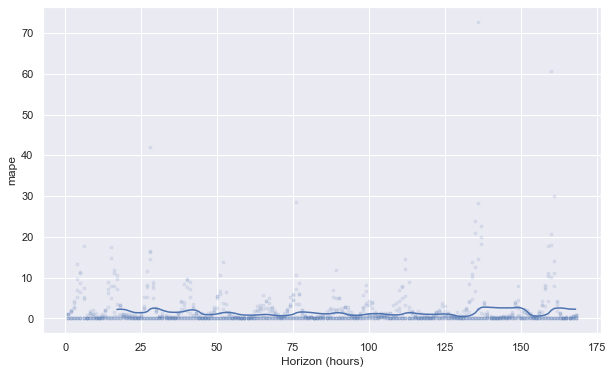

In [321]:
fig = plot_cross_validation_metric(df_cv, metric='mape')

Tutaj model wygląda już delikatnie mówiąc na beznadziejny. Spróbujemy sztuczki z `floor` i zobaczymy czy to coś zmieni.

In [324]:
le_0_mask = df_cv['yhat'].le(0)
df_cv.loc[le_0_mask, 'yhat'] = floor

In [326]:
le_0_mask = df_cv['yhat_lower'].le(0)
df_cv.loc[le_0_mask, 'yhat_lower'] = floor

In [328]:
le_0_mask = df_cv['yhat_upper'].le(0)
df_cv.loc[le_0_mask, 'yhat_upper'] = floor

In [330]:
df_p = performance_metrics(df_cv)

In [331]:
df_p['mape'].describe()

count    152.000000
mean       1.202988
std        0.641347
min        0.362101
25%        0.767986
50%        0.982677
75%        1.432339
max        2.783296
Name: mape, dtype: float64

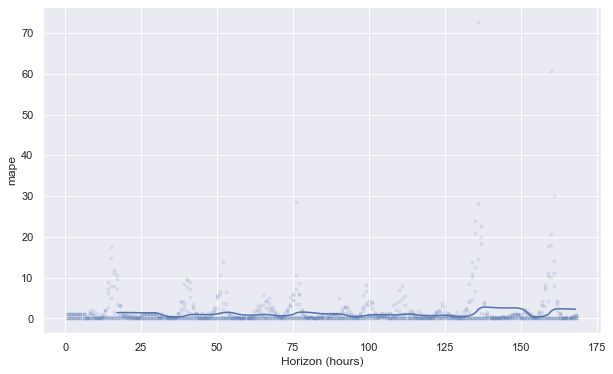

In [332]:
fig = plot_cross_validation_metric(df_cv, metric='mape')

Niewiele to zmieniło, ale też bardzo prymitywnie oczyściliśmy dane.

Nie zrażamy się tym jednak, ponieważ:
* cały dataset oczyścimy trochę lepiej
* przewidywanie dla najbliższych 7 dni nie wyglądało tak źle

## Pełny dataset

Ponieważ danych w ściągniętych CSVakach jest około 3.4 GB posłużymy się biblioteką Dask, zamiast wczytywać je do jednej wielkiej pandasowej ramki danych.

In [11]:
import dask.dataframe as dd
from dask.diagnostics import ProgressBar

In [7]:
ddf = dd.read_csv(DATA_FOLDER / 'yellow_tripdata_*.csv', include_path_column=True, parse_dates=[1, 2], 
                  dtype={'store_and_fwd_flag': 'category',
                         'RatecodeID': 'float64',
                         'VendorID': 'float64', 
                         'passenger_count': 'float64',
                         'payment_type': 'float64',
                         'tolls_amount': 'float64'})

In [12]:
with ProgressBar():
    display(ddf.head())

[########################################] | 100% Completed |  3.5s


VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0       1.0  2020-01-01 00:28:15   2020-01-01 00:33:03              1.0   
1       1.0  2020-01-01 00:35:39   2020-01-01 00:43:04              1.0   
2       1.0  2020-01-01 00:47:41   2020-01-01 00:53:52              1.0   
3       1.0  2020-01-01 00:55:23   2020-01-01 01:00:14              1.0   
4       2.0  2020-01-01 00:01:58   2020-01-01 00:04:16              1.0   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0            1.2         1.0                  N           238           239   
1            1.2         1.0                  N           239           238   
2            0.6         1.0                  N           238           238   
3            0.8         1.0                  N           238           151   
4            0.0         1.0                  N           193           193   

   payment_type  fare_amount  extra  mta_tax  tip_amount  tolls_amount  \
0           1.0          6.0    3.0      0.5        1.47           0.0   
1           1.0          7.0    3.0      0.5        1.50           0.0   
2           1.0          6.0    3.0      0.5        1.00           0.0   
3           1.0          5.5    0.5      0.5        1.36           0.0   
4           2.0          3.5    0.5      0.5        0.00           0.0   

   improvement_surcharge  total_amount  congestion_surcharge  \
0                    0.3         11.27                   2.5   
1                    0.3         12.30                   2.5   
2                    0.3         10.80                   2.5   
3                    0.3          8.16                   0.0   
4                    0.3          4.80                   0.0   

                                                path  
0  C:/Users/fszyler/Documents/Jupyter/kinesso/dat...  
1  C:/Users/fszyler/Documents/Jupyter/kinesso/dat...  
2  C:/Users/fszyler/Documents/Jupyter/kinesso/dat...  
3  C:/Users/fszyler/Documents/Jupyter/kinesso/dat...  
4  C:/Users/fszyler/Documents/Jupyter/kinesso/dat...

In [13]:
with ProgressBar():
    display(ddf.tail())

[########################################] | 100% Completed |  3.5s


VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
708738       NaN  2021-07-09 18:07:09   2021-07-09 18:27:04              NaN   
708739       NaN  2021-07-09 18:16:00   2021-07-09 18:57:00              NaN   
708740       NaN  2021-07-09 18:07:46   2021-07-09 19:07:06              NaN   
708741       NaN  2021-07-09 18:17:00   2021-07-09 18:42:00              NaN   
708742       NaN  2021-07-09 18:11:00   2021-07-09 18:30:00              NaN   

        trip_distance  RatecodeID store_and_fwd_flag  PULocationID  \
708738           2.60         NaN                NaN            68   
708739          12.47         NaN                NaN            92   
708740           3.01         NaN                NaN           265   
708741           6.67         NaN                NaN           262   
708742           3.51         NaN                NaN           232   

        DOLocationID  payment_type  fare_amount  extra  mta_tax  tip_amount  \
708738           144           NaN        14.00   1.00      0.5        2.75   
708739           144           NaN        47.08   2.75      0.5        0.00   
708740           249           NaN        23.96   0.00      0.5        0.00   
708741           211           NaN        24.24   0.00      0.5        5.96   
708742            68           NaN        15.27   0.00      0.5        3.96   

        tolls_amount  improvement_surcharge  total_amount  \
708738           0.0                    0.3         21.05   
708739           0.0                    0.3         50.63   
708740           0.0                    0.3         24.76   
708741           0.0                    0.3         33.50   
708742           0.0                    0.3         22.53   

        congestion_surcharge  \
708738                   2.5   
708739                   0.0   
708740                   0.0   
708741                   2.5   
708742                   2.5   

                                                     path  
708738  C:/Users/fszyler/Documents/Jupyter/kinesso/dat...  
708739  C:/Users/fszyler/Documents/Jupyter/kinesso/dat...  
708740  C:/Users/fszyler/Documents/Jupyter/kinesso/dat...  
708741  C:/Users/fszyler/Documents/Jupyter/kinesso/dat...  
708742  C:/Users/fszyler/Documents/Jupyter/kinesso/dat...

In [14]:
with ProgressBar():
    display(ddf.info())

<class 'dask.dataframe.core.DataFrame'>
Columns: 19 entries, VendorID to path
dtypes: category(1), category(1), datetime64[ns](2), float64(13), int64(2)

None

Sprawdżmy ile mamy rekordów.

In [15]:
with ProgressBar():
    display(ddf.shape[0].compute())

[########################################] | 100% Completed |  1min 59.4s


39649199

39.6 G rekordów.

In [10]:
with ProgressBar():
    print(ddf.isnull().sum().compute())

[########################################] | 100% Completed |  2min  5.0s
VendorID                 1643596
tpep_pickup_datetime           0
tpep_dropoff_datetime          0
passenger_count          1643596
trip_distance                  0
RatecodeID               1643596
store_and_fwd_flag       1643596
PULocationID                   0
DOLocationID                   0
payment_type             1643596
fare_amount                    0
extra                          0
mta_tax                        0
tip_amount                     0
tolls_amount                   0
improvement_surcharge          0
total_amount                   0
congestion_surcharge           0
path                           0
dtype: int64


1.6 G NaNów do usunięcia

Zacznijmy trochę czyścić nasz zbiór.
1. usuńmy NaNy
1. odfiltrujmy tylko interesujące nas `PULocationID`
1. usuńmy na postawie kolumny `VendorID` rekordy z wartościami różnymi od `1` i `2` (takie jak w słowniku danych)
1. usuńmy na podstawie kolumny `RatecodeID` rekordy z wartościami poza zakresem 1-6 (taki jak w słowniku danych)
1. usuńmy na podstawie kolumny `payment_type` rekordy o wartościach `3` (`No charge`), `4` (`Dispute`), `6` (`Voided trip`) (innymi słowy zostawiamy wartości `1`, `2`, i `5`)
1. usuńmy na podstawie kolumny `store_and_fwd_flag` rekordy z wartościami innymi niż `N` lub `Y` (takie jak w słowniku danych)
1. usuńmy rekordy z wartościami mniejszymi-równymi `0` dla kolumn dla których nie ma to sensu
   1. ilości pasażerów `passenger_count`
   1. długości podróży `trip_distance`
   1. oplacie naliczonej przez taksometr `fare_amount`
   1. całkowitej kwocie do zapłacenia `total_amount`
1. usuwała rekordy z wartościami mniejszymi od `0` dla kolumn dla których nie ma to sensu
   1. dodatkowe nałożone opłaty `extra`
   1. podatek MTA `mta_tax`
   1. kwota napiwku `tip_amount`
   1. kwota opłat drogowych `tolls_amount`
   1. dodatkowa opłata `improvement_surcharge`
   1. opłata "korkowa" `congestion_surcharge`
1. usuńmy rekordy gdzie `tpep_dropoff_datetime` <= `tpep_pickup_datetime`
1. usuńmy zduplikowane rekordy

Praktycznie nie znam Daska i coś buntuje mi się maszyna, więc najpierw zapiszmy dane do formatu Parquet, może trochę przyspeiszy to całość.

In [ ]:
ddf.to_parquet(DATA_FOLDER)

Hmm, kernel padł, ciekawe czy eksport doszedł do skutku. (pewnie robienie tego w tym samym notatniku co poprzednich danych to nie jest dobry pomysł - chociaż próbuję jż nawet po ponowym otwarciu notatnika, a więc bez ładowania poprzednich danych)

In [6]:
ddf = dd.read_parquet(DATA_FOLDER)

Corrupted thrift data at  109197 :  6 14
Corrupted thrift data at  109201 :  12 0
Corrupted thrift data at  109209 :  4 14
Corrupted thrift data at  109211 :  15 11
Corrupted thrift data at  109212 :  30 14
Corrupted thrift data at  109213 :  38 11
Corrupted thrift data at  109214 :  45 15
Corrupted thrift data at  109217 :  61 0
Corrupted thrift data at  109218 :  63 0
Corrupted thrift data at  109221 :  6 14
Corrupted thrift data at  109225 :  4 0
Corrupted thrift data at  109226 :  7 14
Corrupted thrift data at  109233 :  5 14
Corrupted thrift data at  109234 :  5 13
Corrupted thrift data at  109237 :  0 15
Corrupted thrift data at  109197 :  6 14
Corrupted thrift data at  109201 :  15 0


KeyError: 1

Dane uszkodzone, może spróbujemy pobawić się daskiem w osobnym notebooku - `nyc_yellow_taxi_dask.ipynb`.